In [1]:
import pandas as pd
from textblob import TextBlob
import math
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from tqdm import tqdm

#define RMSE
# l1-true,l2-false
def RMSE(l1, l2):
    length = len(l1)
    sum = 0
    for i in range(length):
        sum = sum + np.square(l1[i] - l2[i])
    return math.sqrt(sum / length)


#define MAE
def MAE(l1, l2):
    n = len(l1)
    l1 = np.array(l1)
    l2 = np.array(l2)
    mae = sum(np.abs(l1 - l2)) / n
    return mae


#def MAPE
def MAPE(l1, l2):
    n = len(l1)
    l1 = np.array(l1)
    l2 = np.array(l2)
    for i in range(len(l1)):
        if l1[i] == 0:
            l1[i] = 0.01
    mape = sum(np.abs((l1 - l2) / l1)) / n
    return mape

# new model for each time
def get_model():
    return AdaBoostRegressor(base_estimator=DecisionTreeRegressor(
        splitter="random", max_depth=1, min_samples_split=3),
                            n_estimators=30,
                            learning_rate=0.01)



df_normalized_polarity_price = pd.read_csv("normalized_polarity_price.csv")
df_normalized_polarity_price.date = pd.to_datetime(
    df_normalized_polarity_price.date)
lag_dict = {'normalized_polarity': 4, 'normalized_price': 2}




num of feature is 2, rmse=0.06389655749051752, mae=0.047070758889942894, mape=0.13479148824502055
num of feature is 3, rmse=0.09600600956629594, mae=0.07538410152995463, mape=0.1979212187698543
num of feature is 4, rmse=0.10346554818208362, mae=0.08224969902140841, mape=0.21813165611887225
num of feature is 5, rmse=0.11262894437180236, mae=0.08849211593699367, mape=0.22902911852737057
num of feature is 6, rmse=0.11684937507561748, mae=0.09395598458131547, mape=0.2436610113997975


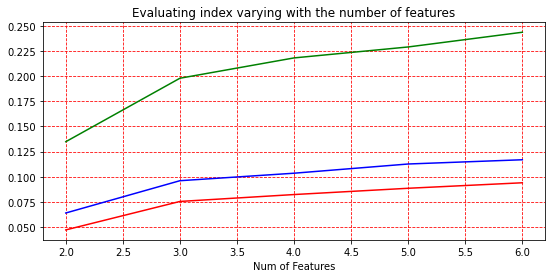

step = 0, the rmse, mae and mape are 0.06, 0.05, 0.13 respectively:


In [2]:


frame = []
series_index = 1
for each_type in lag_dict:
    lag = lag_dict[each_type]
    ts = df_normalized_polarity_price[each_type].tolist()
    df = pd.DataFrame(ts)
    n_vars = 1 if type(ts) is list else ts.shape[1]
    cols, names = list(), list()
    # input sq(t-n,...,t-1)
    for i in range(lag, 0, -1):
        cols.append(df.shift(i))
        names += [('(t-%d)%d' % (i, j + 1)) for j in range(n_vars)]
    # forecast sq(t,t+1,..,t+n)
    for i in range(0, 1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('(t)%d' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('(t+%d)' % (j + 1)) for j in range(n_vars)]
    # put it all together
    df_shifted_series = pd.concat(cols, axis=1)
    df_shifted_series.columns = names
    # drop rows with NaN values
    df_shifted_series.dropna(inplace=True)
    colList = df_shifted_series.columns
    length = len(colList)
    df_shifted_series.columns = [
        'var' + str(series_index) + '(t-%d)' % (length - 1 - i)
        for i in range(length)
    ]
    series_index += 1
    frame.append(df_shifted_series)

df_all_shifted_series = pd.concat(frame, axis=1)
df_all_shifted_series.dropna(inplace=True)

for name in df_all_shifted_series.columns:
    if name != 'var2(t-0)':
        # only (t-0) of price should be kept as labels
        if '(t-0)' in name:
            df_all_shifted_series = df_all_shifted_series.drop([name],
                                                                axis=1)

values = df_all_shifted_series.values
# ensure all data is float
values = values.astype('float32')

#Filling Nan with mean
numFeat = np.shape(values)[1]
for i in range(numFeat):
    meanVal = np.mean(values[np.nonzero(~np.isnan(values[:, i]))[0], i])
    #values that are not NaN (a number)
    values[np.nonzero(np.isnan(values[:, i]))[0], i] = meanVal

# split into train and test sets
size = int(len(values) * 2 / 3)
train_xy = values[:size, :]
test_xy = values[size:, :]

# split into input and outputs
train_x, train_y = train_xy[:, :-1], train_xy[:, -1]
test_x, test_y = test_xy[:, :-1], test_xy[:, -1]

# #Data format to be used in RFE model
# train_x = train_2X
# train_y = train_y
# test_x = test_2X
# test_y = test_y

# # preprocessing done, now start regression





rmselist = []
maelist = []
mapelist = []
size = int(len(values) * (2 / 3))
# exclude t-0
for num_of_feature in range(2, len(df_all_shifted_series.columns)):
    rfe = RFE(DecisionTreeRegressor(), n_features_to_select=num_of_feature)
    # feature selection is part of training(learing), no data from test set should be used
    fit = rfe.fit(train_x, train_y)
    feature_choose_list = fit.support_
    ixList = []
    chosen_train_x = []
    chosen_test_x = []
    for i in range(len(feature_choose_list)):
        #print(feature_choose_list[i])
        # numpy._bool == True but not "is True"
        if feature_choose_list[i] == True:
            #print(f"{i} is chosen")
            ixList.append(i)
            chosen_train_x.append(train_x[:, i])
            chosen_test_x.append(test_x[:, i])

    chosen_train_x = np.array(chosen_train_x).T
    chosen_test_x = np.array(chosen_test_x).T

    y_pred = []
    model=get_model()
    model.fit(chosen_train_x, train_y)
    y_pred = model.predict(chosen_test_x)
    rmse = RMSE(list(test_y), y_pred)
    rmselist.append(rmse)
    mae = MAE(list(test_y), y_pred)
    maelist.append(mae)
    mape = MAPE(list(test_y), y_pred)
    mapelist.append(mape)
    print(
        f'num of feature is {num_of_feature}, rmse={rmse}, mae={mae}, mape={mape}'
    )

#plot
plt.figure(figsize=(9, 4))
plt.grid(c='r', ls='--')
plt.plot(range(2, len(rmselist) + 2), rmselist, 'b', label='rmse')
plt.plot(range(2, len(maelist) + 2), maelist, 'r', label='mae')
plt.plot(range(2, len(mapelist) + 2), mapelist, 'g', label='mape')
plt.title('Evaluating index varying with the number of features')
plt.xlabel('Num of Features')
plt.show()

rmselist = np.array(rmselist)
maelist = np.array(maelist)
mapelist = np.array(mapelist)
newlist = (rmselist + maelist + mapelist) / 3
newlist = list(newlist)
index = newlist.index(min(newlist))
# statring from 2 above, +2 back to count
optimal_feature_num = index + 2

print(
    'step = 0, the rmse, mae and mape are %.2f, %.2f, %.2f respectively:' %
    (rmselist[index], maelist[index], mapelist[index]))

# # found optimal number of features to use, now go for real run


In [3]:

rfe = RFE(DecisionTreeRegressor(),
            n_features_to_select=optimal_feature_num)
fit = rfe.fit(train_x, train_y)
feature_choose_list = fit.support_

chosen_train_x = []
chosen_test_x = []
chosen_values = []
for i in range(len(feature_choose_list)):
    #print(feature_choose_list[i])
    # numpy._bool
    if feature_choose_list[i] == True:  
        print(f"{i} is chosen")
        ixList.append(i)
        chosen_train_x.append(train_x[:, i])
        # chosen_test_x.append(test_x[:, i])
        chosen_values.append(values[:, i])
chosen_train_x = np.array(chosen_train_x).T
# chosen_test_x = np.array(chosen_test_x).T
chosen_values = np.array(chosen_values).T    



4 is chosen
5 is chosen


In [7]:

model=get_model()
model.fit(chosen_train_x,train_y)

y_pred_h1 = []
step = 1
for j in tqdm(range(size, len(values))):
    y_pred_h1.append(
        model.predict(chosen_values[j - step, :].reshape(
            (1, -1)))[0])

rmse_h1 = RMSE(list(test_y), y_pred_h1)
mae_h1 = MAE(list(test_y), y_pred_h1)
mape_h1 = MAPE(list(test_y), y_pred_h1)


100%|██████████| 663/663 [00:01<00:00, 350.75it/s]


In [8]:

y_pred_h2 = []
step = 2
for j in tqdm(range(size, len(values))):
    y_pred_h2.append(
        model.predict(chosen_values[j - step, :].reshape(
            (1, -1)))[0])

rmse_h2 = RMSE(list(test_y), y_pred_h2)
mae_h2 = MAE(list(test_y), y_pred_h2)
mape_h2 = MAPE(list(test_y), y_pred_h2)


100%|██████████| 663/663 [00:01<00:00, 343.17it/s]


In [9]:

y_pred_h3 = []
step = 3
for j in tqdm(range(size, len(values))):
    y_pred_h3.append(
        model.predict(chosen_values[j - step, :].reshape(
            (1, -1)))[0])
rmse_h3 = RMSE(list(test_y), y_pred_h3)
mae_h3 = MAE(list(test_y), y_pred_h3)
mape_h3 = MAPE(list(test_y), y_pred_h3)

print(f"rmse_h1={rmse_h1}\n mae_h1 ={mae_h1}\n mape_h1 ={mape_h1}\n")
print(f"rmse_h2={rmse_h2}\n mae_h2 ={mae_h2}\n mape_h2 ={mape_h2}\n")
print(f"rmse_h3={rmse_h3}\n mae_h3 ={mae_h3}\n mape_h3 ={mape_h3}\n")




100%|██████████| 663/663 [00:01<00:00, 397.24it/s]

rmse_h1=0.11444290103948795
 mae_h1 =0.08731085695119616
 mape_h1 =0.22787383233383582

rmse_h2=0.11567104391951219
 mae_h2 =0.08800853269046394
 mape_h2 =0.2293638118178782

rmse_h3=0.11672010044458539
 mae_h3 =0.08862127968211363
 mape_h3 =0.23069908265183856



In [94]:
from pandas.tseries.offsets import DateOffset
df_normalized_polarity_price.date

0      2011-03-29
1      2011-03-30
2      2011-03-31
3      2011-04-01
4      2011-04-04
          ...    
1988   2019-03-18
1989   2019-03-19
1990   2019-03-20
1991   2019-03-21
1992   2019-03-22
Name: date, Length: 1993, dtype: datetime64[ns]

In [ ]:
df_normalized_polarity_price.set_index('date',inplace=True)
pd.to_datetime(df_normalized_polarity_price.index)


In [141]:
df_normalized_polarity_price.tail()

,normalized_polarity,normalized_price
date,,
2019-03-18,0.731557,0.377294
2019-03-19,0.776877,0.377638
2019-03-20,0.761152,0.389106
2019-03-21,0.780255,0.387500
2019-03-22,0.810537,0.374771


In [97]:
new_dates = [df_normalized_polarity_price.index[-1] + DateOffset(days=x) for x in range(1, 4)]
new_dates

[Timestamp('2019-03-23 00:00:00'),
 Timestamp('2019-03-24 00:00:00'),
 Timestamp('2019-03-25 00:00:00')]

In [145]:
h1=np.array(y_pred_h1[-1:]+[np.nan]*2)
h2=np.array(y_pred_h2[-2:]+[np.nan])
h3=np.array(y_pred_h3[-3:])

In [146]:
pred=pd.DataFrame([h1,h2,h3]).T
pred.columns=["h1","h2","h3"]

In [147]:

pred['date'] = new_dates
pred.set_index('date', inplace=True)


In [154]:
df_old_n_new=pd.concat([df_normalized_polarity_price,pred])

In [157]:
df_old_n_new.to_csv("normalized_polarity_price_h1_h2_h3.csv")